<a href="https://colab.research.google.com/github/ppkgtmm/sentiment/blob/GRU2/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# !pip install keras-tuner
# !rm -r sentiment
# !git clone --branch utils https://github.com/ppkgtmm/sentiment.git sentiment

In [5]:
import pandas as pd
from keras.preprocessing.text import  Tokenizer
from keras.layers import Input, Dense, Embedding, LSTM
from keras.models import Sequential
from keras.metrics import Precision, Recall, FalseNegatives, \
FalsePositives, TrueNegatives, TruePositives
from kerastuner import HyperParameters
import matplotlib.pyplot as plt
from sentiment.utils import read_data, get_optimizer, get_sequences, split_data
from sentiment.utils import get_tuner, get_model_from_config, get_callbacks
from sentiment.utils import OH_fit_transform, OH_transform, load, dump, \
model_evaluate

In [6]:
cols = ['text', 'target']
data_path = '/content/drive/MyDrive/sentiment/data/data_preprocessed.csv'
test_path = '/content/drive/MyDrive/sentiment/data/test_data_preprocessed.csv'
seed = 123456
num_words = 10000
max_len = 250
optimizers = [
           'Adam',
           'RMSprop'   
]

In [7]:
data = read_data(data_path,cols)
data.sample(5)

,text,target
328363,good product have not got to use it yet but it...,1
352010,where is the original version of fool this is ...,0
328869,finally a face to put with the great music the...,1
44898,lars is a scary genius lars von trier is a pro...,1
352160,poor performance being a bryan duncan fan i ea...,0


In [8]:
test = read_data(test_path, cols)
test.sample(5)

,text,target
9331,should not be listed in this category these ar...,0
16982,interesting look at tolstoy last days this is ...,1
16586,dating without novacaine was a numbing experie...,0
15413,soldiers live fantastic journey i started read...,1
2248,great these swatches are great for matching co...,1


In [9]:
train, val = split_data(data)

In [10]:
tokenizer = Tokenizer(num_words=num_words, oov_token='OOV')
tokenizer.fit_on_texts(train['text'])

In [11]:
sequence_train = get_sequences(tokenizer, max_len, train['text'])
sequence_val = get_sequences(tokenizer, max_len, val['text'])

In [12]:
print(val['target'].unique(), train['target'].unique())

[1 0] [0 1]


In [13]:
train_target = OH_fit_transform(train['target'])
val_target = OH_transform(val['target'])

In [14]:
def build_lstm(hp):
    model = Sequential()
    model.add(Input(shape=(max_len)))
    model.add(
        Embedding(
          num_words, hp.get('output_dim')
        )
    )
    model.add(LSTM(2 ** hp.get('log2_units')))
    model.add(Dense(2, activation='softmax'))
    model.compile(
        optimizer=get_optimizer(hp.get('optimizer')),
        loss='categorical_crossentropy',
        metrics=[
                 'accuracy',
                 Precision(), 
                 Recall(),
                 TruePositives(), 
                 TrueNegatives(), 
                 FalsePositives(),
                 FalseNegatives()
              ]
          )
    model.summary()
    return model

In [15]:
hp = HyperParameters()
hp.Int('output_dim', 16, 64, 16)
hp.Int('log2_units', 3, 7, 1)
hp.Choice('optimizer', optimizers)

'Adam'

In [16]:
tuner = get_tuner(build_lstm,'/content/drive/MyDrive/sentiment/LSTM',\
                  'LSTM_FIN_B32',hp, 1, 2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 16)           160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 2)                 18        
Total params: 160,818
Trainable params: 160,818
Non-trainable params: 0
_________________________________________________________________


## Train

In [17]:
history = tuner.search(
    sequence_train,
    train_target,
    epochs=1,
    validation_data=(sequence_val, val_target),
    batch_size=32,
    use_multiprocessing=True
)

Trial 1 Complete [00h 15m 19s]
val_loss: 0.1969956010580063

Best val_loss So Far: 0.1969956010580063
Total elapsed time: 00h 15m 19s
INFO:tensorflow:Oracle triggered exit


## Refit

In [18]:
best_model = tuner.get_best_models(num_models=1)[0]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 16)           160000    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                6272      
_________________________________________________________________
dense (Dense)                (None, 2)                 66        
Total params: 166,338
Trainable params: 166,338
Non-trainable params: 0
_________________________________________________________________


In [19]:
best_model = get_model_from_config(
    best_model,
    get_optimizer(tuner.get_best_hyperparameters()[0].get('optimizer'))
)

In [20]:
cb = get_callbacks('lstm.h5')

In [21]:
history = best_model.fit(
    sequence_train,
    train_target,
    validation_data=(sequence_val, val_target),
    epochs=10,
    callbacks=cb
)

Epoch 1/10
9563/9563 [==============================] - 444s 46ms/step - loss: 0.3084 - accuracy: 0.8652 - precision: 0.8652 - recall: 0.8652 - true_positives: 135624.7379 - true_negatives: 135624.7379 - false_positives: 17415.2529 - false_negatives: 17415.2529 - val_loss: 0.1974 - val_accuracy: 0.9248 - val_precision: 0.9248 - val_recall: 0.9248 - val_true_positives: 49940.0000 - val_true_negatives: 49940.0000 - val_false_positives: 4058.0000 - val_false_negatives: 4058.0000

Epoch 00001: val_loss improved from inf to 0.19736, saving model to lstm.h5
Epoch 2/10
9563/9563 [==============================] - 446s 47ms/step - loss: 0.1709 - accuracy: 0.9359 - precision: 0.9359 - recall: 0.9359 - true_positives: 143118.6346 - true_negatives: 143118.6346 - false_positives: 9921.3562 - false_negatives: 9921.3562 - val_loss: 0.1794 - val_accuracy: 0.9324 - val_precision: 0.9324 - val_recall: 0.9324 - val_true_positives: 50347.0000 - val_true_negatives: 50347.0000 - val_false_positives: 3651.0

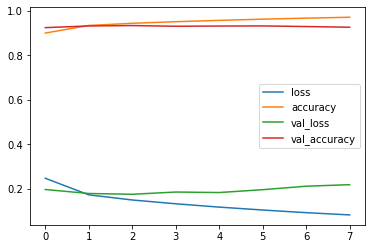

In [22]:
metr = ['loss', 'accuracy', 'val_loss', 'val_accuracy']
pd.DataFrame(history.history)[metr].plot()

In [23]:
# dump(history.history,'/content/drive/MyDrive/sentiment/LSTM/LSTM_FIN_B32/history.pickle')
# dump(tokenizer,'/content/drive/MyDrive/sentiment/LSTM/LSTM_FIN_B32/tokenizer.pickle')

# Test

In [24]:
sequence_test = get_sequences(tokenizer, max_len, test['text'])
test_target = OH_transform(test['target'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 16)           160000    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                6272      
_________________________________________________________________
dense (Dense)                (None, 2)                 66        
Total params: 166,338
Trainable params: 166,338
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


625/625 [==============================] - 9s 14ms/step
Accuracy:	92.2%


              precision    recall  f1-score   support

           0       0.89      0.96      0.93     10000
           1       0.96      0.89      0.92     10000

    accuracy                           0.92     20000
   macro avg       0.92      0.92      0.92     20000
weighted avg       0.92      0.92      0.92     20000



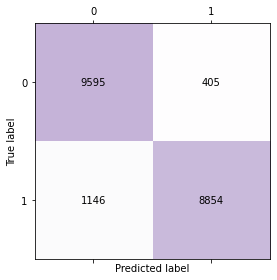

In [25]:
model_evaluate(tuner.get_best_models(num_models=1)[0], sequence_test, \
               test_target, 32)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


625/625 [==============================] - 9s 14ms/step
Accuracy:	93.5%


              precision    recall  f1-score   support

           0       0.93      0.94      0.94     10000
           1       0.94      0.93      0.93     10000

    accuracy                           0.94     20000
   macro avg       0.94      0.94      0.94     20000
weighted avg       0.94      0.94      0.94     20000



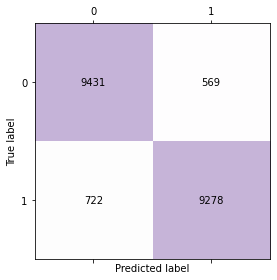

In [26]:
model_evaluate(best_model, sequence_test, \
               test_target, 32)

## Text

In [27]:
tuner.results_summary(num_trials=3)

Results summary
Results in /content/drive/MyDrive/sentiment/LSTM/LSTM_FIN_B32
Showing 3 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
output_dim: 16
log2_units: 5
optimizer: Adam
tuner/epochs: 1
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.1969956010580063


In [28]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
output_dim (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': None}
log2_units (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 7, 'step': 1, 'sampling': None}
optimizer (Choice)
{'default': 'Adam', 'conditions': [], 'values': ['Adam', 'RMSprop'], 'ordered': False}
